In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
folder_path = '/content/drive/MyDrive/Electricity-Power'
os.chdir(folder_path)


Mounted at /content/drive


In [ ]:
!pip install catboost
# from catboost import CatBoostRegressor


In [38]:
import os
import pickle
import requests
from zipfile import ZipFile
from tqdm import tqdm
import warnings
import numpy as np
import numpy
from scipy import stats
from scipy.stats import mstats
import math
warnings.filterwarnings("ignore")
import json
import pandas as pd
import pickle
import seaborn as sns
import random
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import gc
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge

random.seed(42)
from sklearn.decomposition import PCA

np.random.seed(42)


### Data

In [3]:
dates= pd.read_csv('dates.csv')
# df = pd.read_csv('feature_transformed.csv')
df = pd.read_csv('normalized_features.csv')
# df = pd.read_csv('normalized_features_19052_82.csv')
imputed_df = pd.read_csv('transformed_imputed_5_features.csv')
df.shape

(19052, 81)

In [ ]:
df.describe()

Cross-border_physical_flows_Norway (export) [MWh]  \
count                                       19048.000000   
mean                                           38.192107   
std                                            95.674470   
min                                             0.000000   
25%                                             0.000000   
50%                                             0.000000   
75%                                             0.000000   
max                                           361.250000   

       Scheduled_commercial_exchanges_Net export [MWh]  \
count                                     1.905200e+04   
mean                                      1.014422e-16   
std                                       1.000026e+00   
min                                      -2.253089e+00   
25%                                      -7.885886e-01   
50%                                      -1.196462e-01   
75%                                       6.946030e-01   
max                                       3.238608e+00   

       price_lag_24hNorthern Italy [€/MWh]  Natural Gas Price  \
count                         1.753800e+04       13009.000000   
mean                          1.283075e-01           0.103427   
std                           9.234891e-01           1.295694   
min                          -3.072961e+00          -1.794118   
25%                          -4.120172e-01          -0.573529   
50%                          -1.999811e-16           0.000000   
75%                           5.879828e-01           0.426471   
max                           4.963008e+00          15.838235   

       Actual_consumption_Total (grid load) [MWh]  \
count                                19047.000000   
mean                                    -0.002255   
std                                      0.633978   
min                                     -1.514357   
25%                                     -0.522272   
50%                                      0.000000   
75%                                      0.477728   
max                                      1.579633   

       price_lag_168hSwitzerland [€/MWh]  \
count                       19008.000000   
mean                            0.013616   
std                             0.815284   
min                            -9.747399   
25%                            -0.461345   
50%                             0.000000   
75%                             0.538655   
max                             4.028554   

       Scheduled_commercial_exchanges_Denmark (export) [MWh]  \
count                                       1.905200e+04       
mean                                        2.386875e-17       
std                                         1.000026e+00       
min                                        -1.777332e+00       
25%                                        -5.929888e-01       
50%                                         2.228757e-01       
75%                                         7.358111e-01       
max                                         1.666729e+00       

       price_lag_24hPoland [€/MWh]  Actual_generation_Nuclear [MWh]  \
count                 19044.000000                      9466.000000   
mean                      0.040971                         0.336985   
std                       0.998758                         0.565282   
min                      -3.939306                         0.000000   
25%                      -0.462847                         0.000000   
50%                       0.000000                         0.000000   
75%                       0.537153                         1.000000   
max                      11.751423                         1.459970   

       Renewable Generation  ...  Day-ahead_prices_Netherlands [€/MWh]  \
count          1.905200e+04  ...                          19052.000000   
mean          -6.563905e-17  ...                             89.206362   
std            1.000026e+00  ...           

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19052 entries, 0 to 19051
Data columns (total 67 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   Cross-border_physical_flows_Norway (export) [MWh]                       19048 non-null  float64
 1   Scheduled_commercial_exchanges_Net export [MWh]                         19052 non-null  float64
 2   price_lag_24hNorthern Italy [€/MWh]                                     17538 non-null  float64
 3   Natural Gas Price                                                       13009 non-null  float64
 4   Actual_consumption_Total (grid load) [MWh]                              19047 non-null  float64
 5   price_lag_168hSwitzerland [€/MWh]                                       19008 non-null  float64
 6   Scheduled_commercial_exchanges_Denmark (export) [MWh]                   19052 

### Missing

In [4]:
imputed_cols = ['Natural Gas Price',
'Frequency_Containment_Reserve_Procurement price [€/MW]',
'Automatic_Frequency_Restoration_Reserve_Procurement price (+) [€/MW]',
'Manual_Frequency_Restoration_Reserve_Procurement price (+) [€/MW]',
'Manual_Frequency_Restoration_Reserve_Procurement price (-) [€/MW]']

In [5]:
for col in imputed_cols:
  df[col]= imputed_df[col]

In [8]:
missed = pd.DataFrame({
    'column_name': df.columns,
    'number_of_missing_values': df.isnull().sum(),
    'percentage_of_missing_values': (df.isnull().sum() / len(df)) * 100
})
missed[(missed['percentage_of_missing_values'] >0)]

column_name  \
price_lag_24hNorthern Italy [€/MWh]                               price_lag_24hNorthern Italy [€/MWh]   
Manual_Frequency_Restoration_Reserve_Volume pro...  Manual_Frequency_Restoration_Reserve_Volume pr...   
Actual_generation_Nuclear [MWh]                                       Actual_generation_Nuclear [MWh]   
price_lag_168hNorthern Italy [€/MWh]                             price_lag_168hNorthern Italy [€/MWh]   
Automatic_Frequency_Restoration_Reserve_Volume ...  Automatic_Frequency_Restoration_Reserve_Volume...   
Costs_of_TSOs__without_costs_of_DSOs__Network s...  Costs_of_TSOs__without_costs_of_DSOs__Network ...   
Costs_of_TSOs__without_costs_of_DSOs__Countertr...  Costs_of_TSOs__without_costs_of_DSOs__Countert...   
Automatic_Frequency_Restoration_Reserve_Procure...  Automatic_Frequency_Restoration_Reserve_Procur...   
Day-ahead_prices_Northern Italy [€/MWh]                       Day-ahead_prices_Northern Italy [€/MWh]   

                                                    number_of_missing_values  \
price_lag_24hNorthern Italy [€/MWh]                                     1514   
Manual_Frequency_Restoration_Reserve_Volume pro...                     14710   
Actual_generation_Nuclear [MWh]                                         9586   
price_lag_168hNorthern Italy [€/MWh]                                    1514   
Automatic_Frequency_Restoration_Reserve_Volume ...                     14710   
Costs_of_TSOs__without_costs_of_DSOs__Network s...                      1512   
Costs_of_TSOs__without_costs_of_DSOs__Countertr...                      1512   
Automatic_Frequency_Restoration_Reserve_Procure...                     14710   
Day-ahead_prices_Northern Italy [€/MWh]                                 1512   

                                                    percentage_of_missing_values  
price_lag_24hNorthern Italy [€/MWh]                                     7.946672  
Manual_Frequency_Restoration_Reserve_Volume pro...                     77.209742  
Actual_generation_Nuclear [MWh]                                        50.314928  
price_lag_168hNorthern Italy [€/MWh]                                    7.946672  
Automatic_Frequency_Restoration_Reserve_Volume ...                     77.209742  
Costs_of_TSOs__without_costs_of_DSOs__Network s...                      7.936175  
Costs_of_TSOs__without_costs_of_DSOs__Countertr...                      7.936175  
Automatic_Frequency_Restoration_Reserve_Procure...                     77.209742  
Day-ahead_prices_Northern Italy [€/MWh]                                 7.936175

In [7]:
columns_to_fill = missed[(missed['percentage_of_missing_values'] < 5) & (missed['percentage_of_missing_values'] >0)].index
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].median())

In [ ]:
columns_to_remove = missed[missed['percentage_of_missing_values'] > 0].index
# df.drop(columns=columns_to_remove, inplace=True)
df[columns_to_remove] = df[columns_to_remove].fillna(df[columns_to_remove].median())

In [ ]:
missed = pd.DataFrame({
    'column_name': df.columns,
    'number_of_missing_values': df.isnull().sum(),
    'percentage_of_missing_values': (df.isnull().sum() / len(df)) * 100
})
missed[(missed['percentage_of_missing_values'] >0)]

Empty DataFrame
Columns: [column_name, number_of_missing_values, percentage_of_missing_values]
Index: []

### correlated

In [ ]:
price_cols = [col for col in df.columns if 'day-ahead_prices' in col.lower()]
feature_cols = [col for col in df.columns if col not in price_cols]

# Compute full correlation matrix once (more efficient)
corr_matrix = df.corr(numeric_only=True)

# Filter features correlated with multiple price columns
correlated_features = []
for target in price_cols:
    # Get correlations for current target
    target_correlations = corr_matrix[target]

    # Filter features with |correlation| > 0.3 (excluding self-correlation)
    high_corr = target_correlations[
        (abs(target_correlations) > 0.5) &
        (target_correlations.index != target)
    ]

    correlated_features.append(high_corr.index.tolist())
correlated_union_features = set.union(*map(set, correlated_features))
len(correlated_union_features)


35

### PCA

In [ ]:

price_cols = [col for col in df.columns if 'day-ahead_prices' in col.lower()]
feaatures = [col for col in df.columns if col not in price_cols]

numeric_data = df[feaatures].select_dtypes(include='number')
pca = PCA(n_components=0.95)  # Retain 95% of the variance
features_reduced = pca.fit_transform(numeric_data)
total_df = pd.DataFrame(features_reduced, columns=[f'PC{i+1}' for i in range(features_reduced.shape[1])])
total_df[price_cols] = df[price_cols]

In [ ]:
total_df.shape

(19052, 44)

### model

In [16]:
def model_pipeline(model_type, df, target, cross_val=False, grid_search=False, transform=False):
    # Check if all target columns exist in the dataframe
    if all(cols in df.columns for cols in target):
        print('All target columns are present. Starting pipeline...')
    else:
        raise ValueError("Some target columns are missing in the dataframe.")

    # Transformation step (if enabled)
    if transform:
        print("Applying transformations to targets...")
        original_target = df[target].copy()

        # Apply Box-Cox transformation to each target column
        boxcox_lambdas = {}
        for col in target:
            df[col] = df[col].apply(lambda x: x if x >= 0 else 0)
            df[col], boxcox_lambda = stats.boxcox(df[col] + 1)
            boxcox_lambdas[col] = boxcox_lambda
            lower_percentile = np.percentile(df[col], 1)
            upper_percentile = np.percentile(df[col], 99)
            df[col] = np.clip(df[col], lower_percentile, upper_percentile)

        # Scale the transformed targets
        scaler = StandardScaler()
        df[target] = scaler.fit_transform(df[target])

    # Splitting data into features (X) and targets (y)
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if transform:
        y_test_original = original_target.loc[y_test.index]
        print('y_test_original shape:', y_test_original.shape)
    else:
        y_test_original = y_test

    # Further split for grid search (if applicable)
    X_grid, _, y_grid, _ = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

    # Define model and parameter grid based on selected model type
    if model_type.lower() == 'random_forest':
        model = RandomForestRegressor(n_estimators=100,
                                      random_state=42,
                                      max_depth= None,
                                      max_features= 0.5,
                                      min_samples_leaf= 1,
                                      min_samples_split= 2,
                                      )
        param_grid = {
            'n_estimators': [100],
            'max_depth': [None, 2, 4],
            'min_samples_split': [2, 4],
            'min_samples_leaf': [1, 3],
            'max_features': ['auto', 'sqrt', 0.5, 0.75, 1.0]
        }
    elif model_type.lower() == 'xgboost':
        model = XGBRegressor(n_estimators=100,
                             random_state=42,
                             gamma=0,
                             learning_rate=0.1,
                             max_depth=4,
                             subsample=0.5)
        param_grid = {
            'n_estimators': [100],
            'max_depth': [2, 4],
            'learning_rate': [0.01, 0.1],
            'gamma': [0, 1.0],
            'subsample': [0.5, 1.0]
        }
    elif model_type.lower() == 'catboost':
        model = CatBoostRegressor(iterations=300, random_seed=42)
        param_grid = {
            'iterations': [100, 300],
            'depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'l2_leaf_reg': [0, 0.5, 1.0],
            'border_count': [32, 64]
        }
    else:
        raise ValueError("Unsupported model_type. Choose from 'random_forest', 'xgboost', or 'catboost'.")

    # Perform grid search hyperparameter tuning (if enabled)
    if grid_search:
        print("Starting grid search for hyperparameter tuning...")
        print('Data for grid search:', X_grid.shape)
        grid = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1)
        grid.fit(X_grid, y_grid)
        print("Best parameters from Grid Search:", grid.best_params_)
        best_model = grid.best_estimator_
    else:
        best_model = model

    # Perform cross-validation (if enabled)
    if cross_val:
        print("Performing 5-fold cross-validation...")
        cv_scores = cross_val_score(best_model,
                                    X,
                                    y,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    n_jobs=-1)
        print("Cross Validation Scores (neg MSE):", cv_scores)
        print("Mean CV Score (neg MSE):", cv_scores.mean())

    # Train the final model on the training set
    print("Training the model...")
    best_model.fit(X_train, y_train)

    print("Model training is complete.")

    # Feature importance extraction and visualization
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
        imp_df = pd.DataFrame({'feature': X_train.columns,
                               'importance': importances})
        imp_df.sort_values(by='importance', ascending=False, inplace=True)

        print("Feature Importances:")
        print(imp_df)

        imp_df.plot(kind='bar', x='feature', y='importance', figsize=(12, 8),
                    title="Feature Importances")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    else:
        print("The selected model does not support a 'feature_importances_' attribute.")
#---------------------------------------- Prediction -------------------------------------------
    print('Making predictions...')

    if transform:
        y_pred_scaled = best_model.predict(X_test).reshape(-1, len(target))

        # Inverse scaling and Box-Cox transformation for each target column
        y_pred_original_dict = {}

        for i, col in enumerate(target):
            y_pred_boxcox_col = scaler.inverse_transform(y_pred_scaled)[:, i]
            y_pred_original_dict[col] = inv_boxcox(y_pred_boxcox_col + 1e-9,
                                                   boxcox_lambdas[col]) - 1

        y_pred_original = pd.DataFrame(y_pred_original_dict,
                                       index=X_test.index,
                                       columns=target)

    else:
        y_pred_original = pd.DataFrame(best_model.predict(X_test),
                                       index=X_test.index,
                                       columns=target)
    y_pred_clean = y_pred_original
    y_test_clean = y_test_original

    mse = mean_squared_error(y_test_clean.values, y_pred_clean.values)
    mae = mean_absolute_error(y_test_clean.values, y_pred_clean.values)
    r2 = r2_score(y_test_clean.values, y_pred_clean.values)
    rmse = math.sqrt(mse)
    print(f"Root Mean Square Error: {rmse}")
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R² Score:", r2)

    threshold = 0.10 * np.mean(y_test_clean)
    extreme_actual = np.abs(np.diff(y_pred_clean)) > threshold
    extreme_predicted = np.abs(np.diff(y_pred_clean)) > threshold
    extreme_actual = extreme_actual[:len(extreme_predicted)]
    extreme_accuracy = accuracy_score(extreme_actual, extreme_predicted)
    print(f"Total extreme price movment accuracy: {extreme_accuracy * 100:.2f}%")

    # print("\nAnalyzing directional prediction accuracy...")
    # directional_results = calculate_directional_accuracy(y_test_clean, y_pred_clean)

    # for col, results in directional_results.items():
    #     print(f"\nDirectional Accuracy for {col}:")
    #     print(f"Overall: {results['overall_accuracy']:.2f}%")
    #     for direction, metrics in results['direction_metrics'].items():
    #         print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")
    # # # Visualize movement comparison
    # cm = plot_direction_confusion_matrix(y_test_clean, y_pred_clean, target, stable_threshold=0.01)
    # plot_prediction_movements(y_test_clean, y_pred_clean, window_size=7)

    return best_model , X_test , y_test_clean , y_pred_clean




### Analysis

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def uncertainty_quantification_pipeline(X, y, price_cols, n_bootstrap=100, confidence=0.95):
    """
    Enhanced ensemble pipeline with uncertainty quantification

    Parameters:
    X (pd.DataFrame): Feature matrix
    y (pd.DataFrame): Target prices
    price_cols (list): List of price column names
    n_bootstrap (int): Number of bootstrap iterations
    confidence (float): Confidence level (0-1)

    Returns:
    dict: Contains predictions, intervals, and metrics
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize models
    base_models = [
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=100, random_state=42))
    ]

    # Bootstrap-based uncertainty quantification
    bootstrap_preds = []
    for _ in range(n_bootstrap):
        # Bootstrap sample
        idx = np.random.choice(X_train.index, size=len(X_train), replace=True)
        X_boot = X_train.loc[idx]
        y_boot = y_train.loc[idx]

        # Train ensemble
        ensemble = MultiOutputRegressor(
            StackingRegressor(
                estimators=base_models,
                final_estimator=LinearRegression()
            )
        )
        ensemble.fit(X_boot, y_boot)

        # Store predictions
        bootstrap_preds.append(ensemble.predict(X_test))

    # Calculate prediction statistics
    bootstrap_preds = np.array(bootstrap_preds)
    mean_pred = np.mean(bootstrap_preds, axis=0)
    std_pred = np.std(bootstrap_preds, axis=0)
    z_score = norm.ppf((1 + confidence) / 2)

    # Calculate intervals
    lower = mean_pred - z_score * std_pred
    upper = mean_pred + z_score * std_pred

    # Calculate metrics
    metrics = {
        'mse': mean_squared_error(y_test, mean_pred),
        'mae': mean_absolute_error(y_test, mean_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, mean_pred)),
        'r2': r2_score(y_test, mean_pred)
    }

    return {
        'X_test': X_test,
        'y_test': y_test,
        'mean_pred': pd.DataFrame(mean_pred, columns=price_cols, index=X_test.index),
        'lower_bound': pd.DataFrame(lower, columns=price_cols, index=X_test.index),
        'upper_bound': pd.DataFrame(upper, columns=price_cols, index=X_test.index),
        'metrics': metrics
    }

# Usage Example:
results = uncertainty_quantification_pipeline(
    X=data.drop(price_cols, axis=1),
    y=data[price_cols],
    price_cols=price_cols,
    n_bootstrap=100,
    confidence=0.95
)

# Display results
print("Model Metrics:")
for metric, value in results['metrics'].items():
    print(f"{metric.upper()}: {value:.4f}")

print("\nPrediction Intervals (first 5 samples):")
for col in price_cols:
    print(f"\n{col} 95% Confidence Intervals:")
    print(pd.concat([
        results['lower_bound'][col].head().rename('Lower'),
        results['mean_pred'][col].head().rename('Prediction'),
        results['upper_bound'][col].head().rename('Upper')
    ], axis=1))


KeyboardInterrupt: 

In [32]:
def generate_price_change_explanation(shap_values, instance_idx, features):
    explanation = []
    for i in range(shap_values.shape[1]):
        impact = shap_values[instance_idx][i]
        if abs(impact) > 0.01:  # Threshold for significant features
            direction = "increased" if impact > 0 else "decreased"
            explanation.append(f"{features[i]} {direction} prices by ${abs(impact):.2f}")
    return "\n".join(explanation)


In [33]:

def enhanced_feature_analysis(model, X_test, y_test, target_names):
    # Permutation Importance (more reliable with correlated features)
    perm_results = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42
    )

    # SHAP Values for individual prediction explanations
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    return perm_results, shap_values


In [34]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def calculate_confidence_intervals(model, X_test,target_columns ,alpha=0.05, ):
    """ Calculate prediction intervals using forest estimators """
    if not isinstance(model, RandomForestRegressor):
        raise ValueError("Confidence intervals currently only supported for RandomForest")

    # Get predictions from all trees
    predictions = np.stack([tree.predict(X_test) for tree in model.estimators_])

    # Calculate percentiles (adjust for multiple targets)
    lower = np.percentile(predictions, (alpha/2)*100, axis=0)
    upper = np.percentile(predictions, (1-alpha/2)*100, axis=0)

    return lower, upper




In [35]:

def plot_direction_confusion_matrix(y_test, y_pred, target_cols, stable_threshold=0.01):

    # Ensure y_test and y_pred are DataFrames
    if not isinstance(y_test, pd.DataFrame) or not isinstance(y_pred, pd.DataFrame):
        raise ValueError("y_test and y_pred must be pandas DataFrames.")

    # Ensure target_cols exist in both y_test and y_pred
    for col in target_cols:
        if col not in y_test.columns or col not in y_pred.columns:
            raise ValueError(f"Column {col} not found in y_test or y_pred.")

    # Initialize a dictionary to store confusion matrices
    confusion_matrices = {}

    for col in target_cols:
        # Calculate percentage change for actual and predicted values
        actual_change = y_test[col].pct_change().dropna()
        predicted_change = y_pred[col].pct_change().dropna()

        # Align actual and predicted changes
        aligned_index = actual_change.index.intersection(predicted_change.index)
        actual_change = actual_change.loc[aligned_index]
        predicted_change = predicted_change.loc[aligned_index]

        # Classify changes into rise, fall, or stale
        actual_direction = np.where(actual_change > stable_threshold, 'rise',
                                   np.where(actual_change < -stable_threshold, 'fall', 'stale'))
        predicted_direction = np.where(predicted_change > stable_threshold, 'rise',
                                      np.where(predicted_change < -stable_threshold, 'fall', 'stale'))

        # Create confusion matrix
        cm = confusion_matrix(actual_direction, predicted_direction, labels=['rise', 'fall', 'stale'])
        confusion_matrices[col] = cm

        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rise', 'fall', 'stale'],
                    yticklabels=['rise', 'fall', 'stale'])
        plt.title(f'Confusion Matrix for {col}')
        plt.xlabel('Predicted Direction')
        plt.ylabel('Actual Direction')
        plt.show()

    return confusion_matrices


In [36]:
def calculate_directional_accuracy(y_test, y_pred, target_cols=None, stable_threshold=0.01):
    """
    Calculate what percentage of predictions correctly identify the direction
    of movement (rising, falling, or stable).

    Parameters:
    -----------
    y_test : DataFrame - Actual target values
    y_pred : DataFrame - Predicted target values
    target_cols : list - Target columns to analyze
    stable_threshold : float - Threshold for classifying as stable

    Returns:
    --------
    DataFrame - Directional accuracy metrics
    """
    if target_cols is None:
        target_cols = y_test.columns

    results = {}

    for col in target_cols:
        # Calculate percentage changes to determine direction
        test_pct_change = y_test[col].pct_change().fillna(0)
        pred_pct_change = y_pred[col].pct_change().fillna(0)
        # Classify movements as rising, falling, or stable
        def classify_direction(series, threshold):
            directions = pd.Series(index=series.index)
            directions[series > threshold] = 'rising'
            directions[series < -threshold] = 'falling'
            directions[(series >= -threshold) & (series <= threshold)]= 'stable'
            return directions

        test_direction = classify_direction(test_pct_change, stable_threshold)
        pred_direction = classify_direction(pred_pct_change, stable_threshold)

        # Overall directional accuracy
        correct = (test_direction == pred_direction)
        overall_accuracy = correct.mean() * 100

        # Accuracy by direction type
        direction_metrics = {}
        for direction in ['rising', 'falling', 'stable']:
            actual_direction = (test_direction == direction)
            count = actual_direction.sum()

            if count > 0:
                correct_dir = ((test_direction == direction) & (pred_direction == direction)).sum()
                accuracy = (correct_dir / count) * 100
            else:
                correct_dir = 0
                accuracy = 0

            direction_metrics[direction] = {
                'count': int(count),
                'correct': int(correct_dir),
                'accuracy': float(accuracy)
            }

        results[col] = {
            'overall_accuracy': float(overall_accuracy),
            'direction_metrics': direction_metrics
        }

    return results


In [46]:
def plot_prediction_movements(y_test, y_pred, target_cols=None, window_size=7):
    """
    Plot actual vs predicted values with moving averages to visualize trends.

    Parameters:
    -----------
    y_test : DataFrame - Actual target values
    y_pred : DataFrame - Predicted target values
    target_cols : list - Target columns to visualize (defaults to all)
    window_size : int - Window size for moving average
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Handle target columns
    if target_cols is None:
        target_cols = y_test.columns

    # Create visualization
    n_targets = len(target_cols)
    fig, axes = plt.subplots(n_targets, 1, figsize=(12, 5 * n_targets))
    if n_targets == 1:
        axes = [axes]

    for i, col in enumerate(target_cols):
        ax = axes[i]

        # Plot raw values
        ax.plot(dates.loc[y_test.index]['End date'], y_test[col], 'b-', alpha=0.4, label='Actual')
        ax.plot(dates.loc[y_test.index]['End date'], y_pred[col], 'r-', alpha=0.4, label='Predicted')

        # Plot moving averages for clearer trend visualization
        y_test_ma = y_test[col].rolling(window=window_size, center=True, min_periods=1).mean()
        y_pred_ma = y_pred[col].rolling(window=window_size, center=True, min_periods=1).mean()

        ax.plot(dates.loc[y_test.index]['End date'], y_test_ma, 'b-', linewidth=2, label=f'Actual (MA{window_size})')
        ax.plot(dates.loc[y_test.index]['End date'], y_pred_ma, 'r-', linewidth=2, label=f'Predicted (MA{window_size})')

        ax.set_title(f'{col}: Actual vs Predicted Values')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


## imputed missing values

### Random Forest
impute predicted , leave remaining missed , all features included


All target columns are present. Starting pipeline...
Training the model...
Model training is complete.
Feature Importances:
                                              feature  importance
37                                 neighbor_price_avg    0.497953
55                            conventional Generation    0.138625
50             Actual_consumption_Residual load [MWh]    0.047408
31                    Actual_generation_Lignite [MWh]    0.043437
12                 Actual_generation_Fossil gas [MWh]    0.028697
..                                                ...         ...
40                      price_lag_168hAustria [€/MWh]    0.001620
21    Installed_generation_capacity_Wind onshore [MW]    0.001161
32  Manual_Frequency_Restoration_Reserve_Volume pr...    0.000972
60  Automatic_Frequency_Restoration_Reserve_Procur...    0.000873
42  Automatic_Frequency_Restoration_Reserve_Volume...    0.000834

[66 rows x 2 columns]


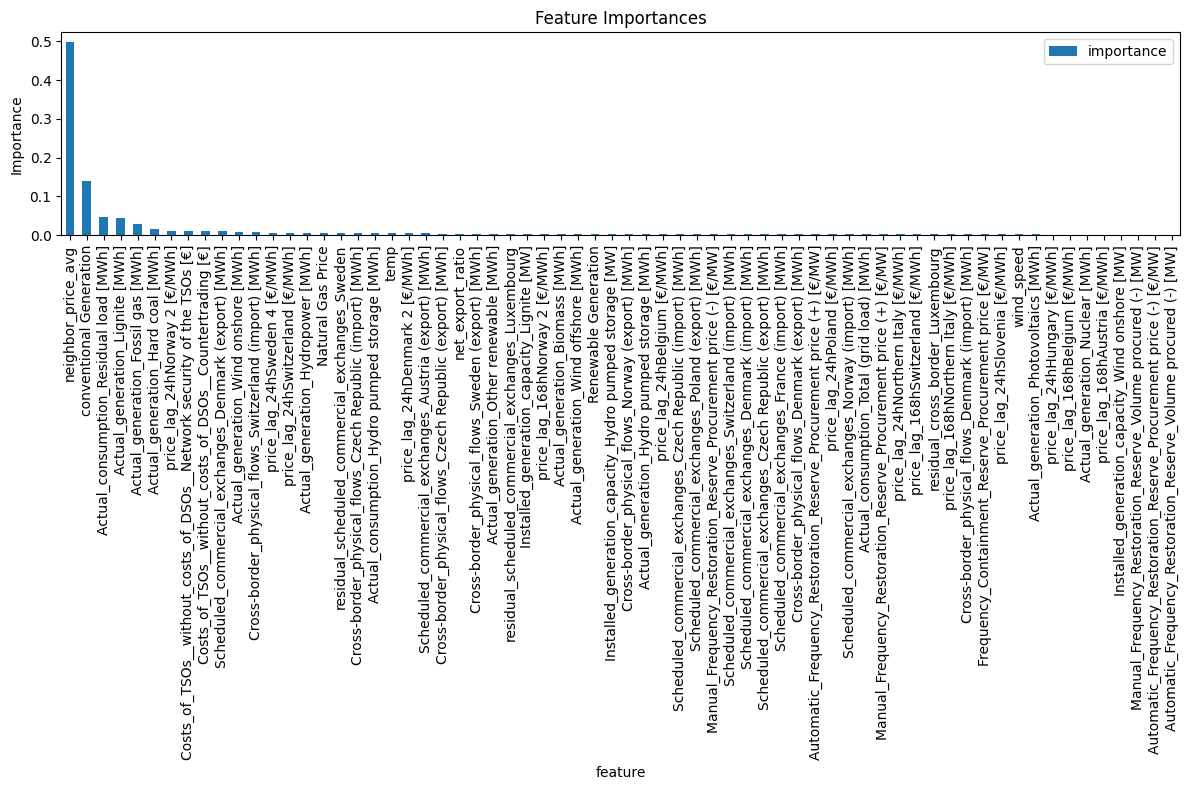

Making predictions...
Root Mean Square Error: 13.256162831763675
Mean Squared Error: 175.7258530222327
Mean Absolute Error: 7.447923356949184
R² Score: 0.9274103381836498
Total extreme price movment accuracy: 100.00%


In [22]:
dff = df.drop(columns=['Day-ahead_prices_Northern Italy [€/MWh]'])
# -------------------------------------------------------------------
price_cols = [col for col in dff.columns if 'day-ahead_prices' in col.lower()]
rf_model , X_test , y_test , predictions = model_pipeline(
                                            model_type="random_forest",
                                            df=dff,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=False,
                                            target=price_cols )


#### shap

In [ ]:

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)


feature_importance = np.abs(shap_values).mean(axis=(0, 2))  # Aggregate across samples and outputs
print("Shape of feature_importance:", feature_importance.shape)  # Should be (66,)

N = 10  # Display top 10 features
top_feature_indices = np.argsort(feature_importance)[::-1][:N]
print("Shape of top_feature_indices:", top_feature_indices.shape)  # Should be (10,)

shap_values_top = shap_values[:, top_feature_indices, :]  # Keep all outputs for top features

shap_values_aggregated = np.mean(shap_values_top, axis=2)  # Mean across outputs
print("Shape of shap_values_aggregated:", shap_values_aggregated.shape)  # Should be (3811, 10)

if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

X_test_top = X_test.iloc[:, top_feature_indices]

# Create the plot
plt.figure()
shap.summary_plot(shap_values_aggregated, X_test_top, feature_names=X_test_top.columns, show=False)
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

### XGBoost
impute predicted , leave remaining missed , all features included

All target columns are present. Starting pipeline...
Training the model...
Model training is complete.
Feature Importances:
                                              feature  importance
37                                 neighbor_price_avg    0.201581
26           Installed_generation_capacity_Lignite MW    0.129349
9                         price_lag_24hNorway 2 €/MWh    0.031897
57  Costs_of_TSOs__without_costs_of_DSOs__Network ...    0.028521
50               Actual_consumption_Residual load MWh    0.028400
..                                                ...         ...
0                          price_lag_24hBelgium €/MWh    0.004388
38   Cross-border_physical_flows_Denmark (export) MWh    0.004207
44  Frequency_Containment_Reserve_Procurement pric...    0.003973
42  Automatic_Frequency_Restoration_Reserve_Volume...    0.003582
32  Manual_Frequency_Restoration_Reserve_Volume pr...    0.003024

[66 rows x 2 columns]


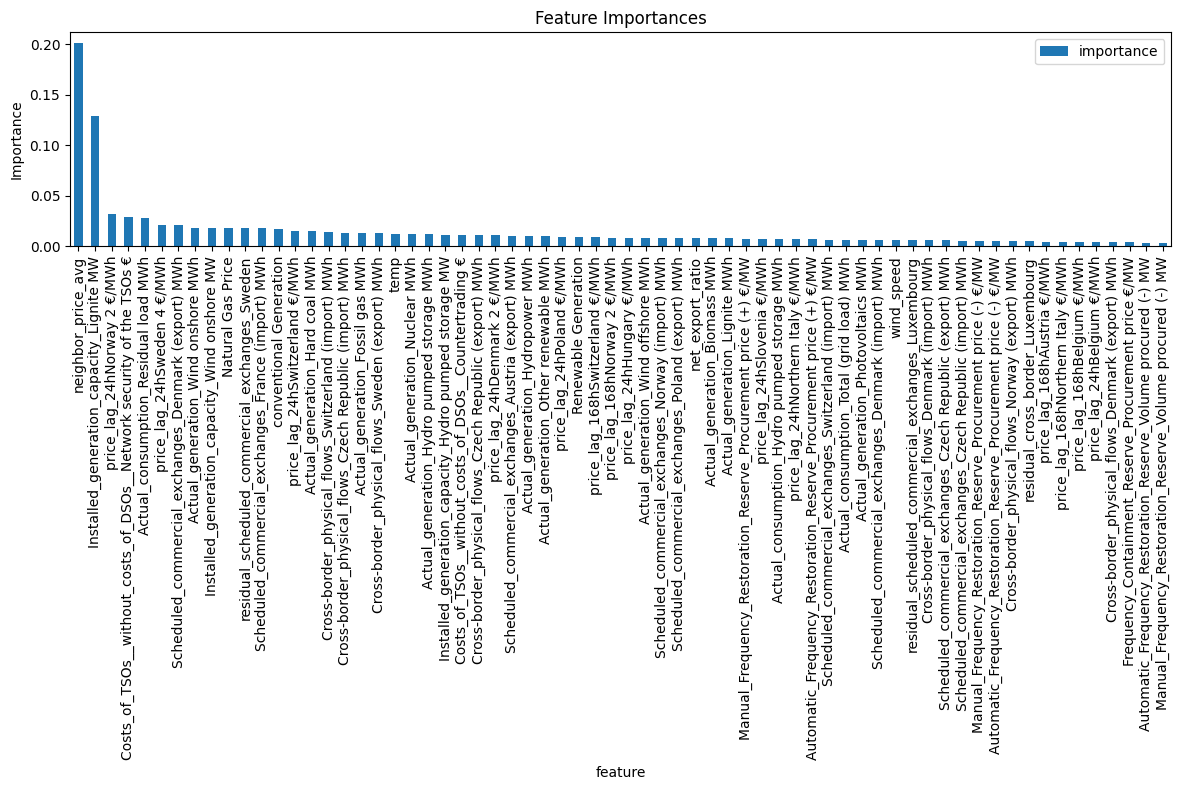

Making predictions...
Root Mean Square Error: 14.139023818162364
Mean Squared Error: 199.91199453056262
Mean Absolute Error: 8.376427031638036
R² Score: 0.9161608301168439
Total extreme price movment accuracy: 100.00%


In [17]:
data = df.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace(',', ''))
data = data.drop(columns=['Day-ahead_prices_Northern Italy €/MWh', ])
# -------------------------------------------------------------------
price_cols = [col for col in data.columns if 'day-ahead_prices' in col.lower()]
xgb_model,X_test, y_test , y_pred_org = model_pipeline(model_type="xgboost",
                                            df=data,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=False,
                                            target =price_cols )

#### shap

Shape of feature_importance: (66,)
Shape of top_feature_indices: (10,)
Shape of shap_values_aggregated: (3811, 10)


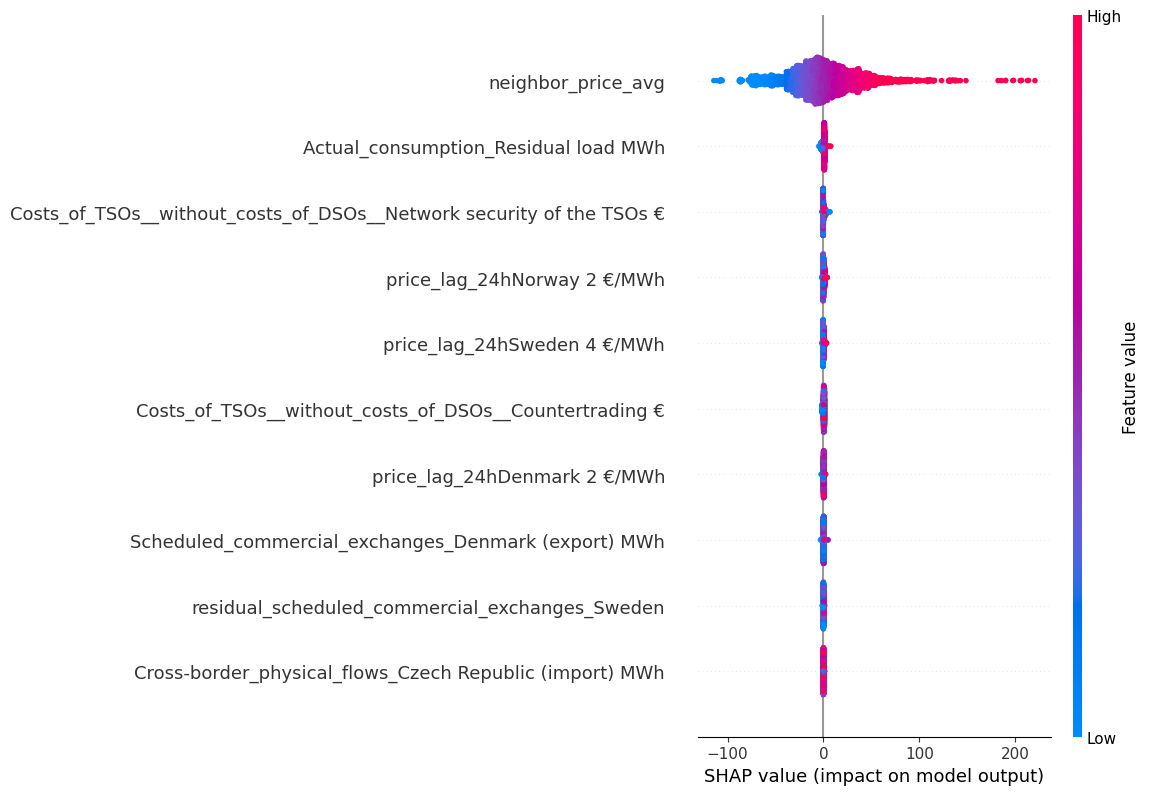

In [ ]:

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


feature_importance = np.abs(shap_values).mean(axis=(0, 2))  # Aggregate across samples and outputs
print("Shape of feature_importance:", feature_importance.shape)  # Should be (66,)

N = 10  # Display top 10 features
top_feature_indices = np.argsort(feature_importance)[::-1][:N]
print("Shape of top_feature_indices:", top_feature_indices.shape)  # Should be (10,)

shap_values_top = shap_values[:, top_feature_indices, :]  # Keep all outputs for top features

shap_values_aggregated = np.mean(shap_values_top, axis=2)  # Mean across outputs
print("Shape of shap_values_aggregated:", shap_values_aggregated.shape)  # Should be (3811, 10)

if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

X_test_top = X_test.iloc[:, top_feature_indices]

# Create the plot
plt.figure()
shap.summary_plot(shap_values_aggregated, X_test_top, feature_names=X_test_top.columns, show=False)
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
plt.show()

#### Lime

In [ ]:
!pip install lime

Missing values in X_train: 59768


<Figure size 1000x2500 with 0 Axes>

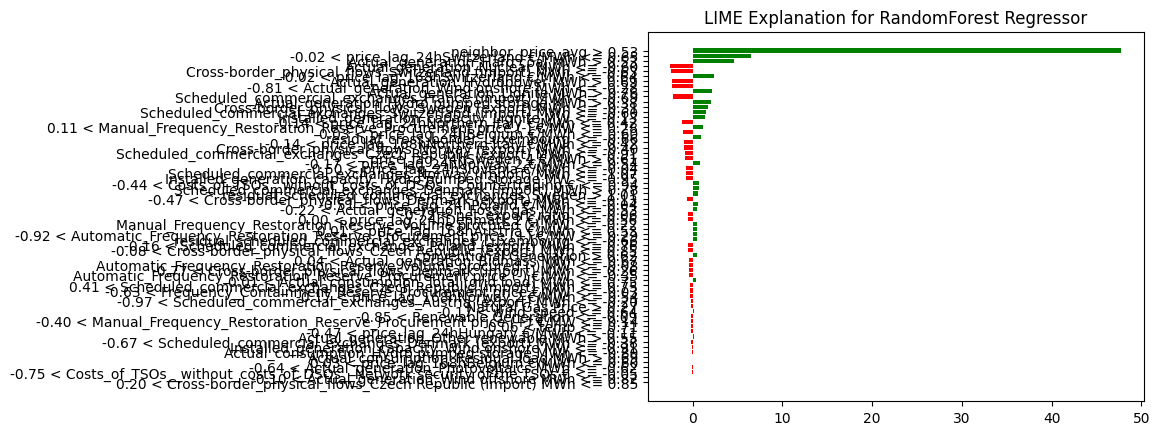

In [29]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lime.lime_tabular

data = df.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace(',', ''))
data = data.drop(columns=['Day-ahead_prices_Northern Italy €/MWh', ])
# -------------------------------------------------------------------
price_cols = [col for col in data.columns if 'day-ahead_prices' in col.lower()]
# Assuming 'data' is your DataFrame
target =price_cols
X = data.drop(target, axis=1)
y = data[target]

# Check for missing values
print("Missing values in X_train:", X.isnull().sum().sum())

# Ensure no missing values
X.fillna(X.median(), inplace=True)  # Replace missing values with mean

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LIME explainer for regression tasks
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    mode='regression',
    feature_names=X_train.columns,
    discretize_continuous=True,
    random_state=42
)

# Choose an instance to explain from the test set
instance = X_test.head(1)

# Explain the XGBoost Regressor prediction
explanation_xgb = explainer.explain_instance(
    data_row=instance.values[0],  # Pass a single row (1D array)
    predict_fn=lambda x: xgb_model.predict(x),  # Use a lambda function for predict
    num_features=len(X_train.columns),
)
plt.figure(figsize=(10, 25))  # Adjust the size as needed (width, height)

# Visualize the explanation for XGBoost
fig_xgb = explanation_xgb.as_pyplot_figure()
plt.title("LIME Explanation for RandomForest Regressor")
plt.show()


### ensemble linear regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Test train split remains the same
original_target = data[price_cols]
X = data.drop(price_cols, axis=1)
y = data[price_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_original = original_target.loc[y_test.index]
print('y_test_original', y_test_original.shape)

# Meta-regressor
meta_reg = LinearRegression()

# Create base estimators
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    # ('catboost', catboost_model)
]

# Wrap StackingRegressor with MultiOutputRegressor
stacking_base = StackingRegressor(estimators=estimators, final_estimator=meta_reg)
stacking_ensemble = MultiOutputRegressor(stacking_base)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Predict on test data - already in correct shape (n_samples, n_targets)
ensemble_predictions = stacking_ensemble.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test_original, ensemble_predictions)
mae = mean_absolute_error(y_test_original, ensemble_predictions)
r2 = r2_score(y_test_original, ensemble_predictions)
rmse = np.sqrt(mse)  # Add RMSE calculation

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)
print("\nAnalyzing directional prediction accuracy...")
pred = pd.DataFrame(ensemble_predictions, columns= y_test_original.columns)
y_test = y_test_original.reset_index()
y_test.drop(columns=['index'], inplace=True)
directional_results = calculate_directional_accuracy(y_test, pred)

for col, results in directional_results.items():
    print(f"\nDirectional Accuracy for {col}:")
    print(f"Overall: {results['overall_accuracy']:.2f}%")
    for direction, metrics in results['direction_metrics'].items():
        print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")


y_test_original (3811, 15)
Mean Squared Error: 156.54697038958614
Mean Absolute Error: 7.004941359619055
Root Mean Squared Error: 12.511873176690457
R² Score: 0.9359850014886903

Analyzing directional prediction accuracy...

Directional Accuracy for Day-ahead_prices_Switzerland €/MWh:
Overall: 93.47%
Rising: 94.70% (1717/1813)
Falling: 94.05% (1835/1951)
Stable: 21.28% (10/47)

Directional Accuracy for Day-ahead_prices_Netherlands €/MWh:
Overall: 89.64%
Rising: 90.25% (1545/1712)
Falling: 91.43% (1868/2043)
Stable: 5.36% (3/56)

Directional Accuracy for Day-ahead_prices_∅ DE/LU neighbours €/MWh:
Overall: 96.67%
Rising: 97.53% (1778/1823)
Falling: 97.58% (1897/1944)
Stable: 20.45% (9/44)

Directional Accuracy for Day-ahead_prices_Belgium €/MWh:
Overall: 90.71%
Rising: 91.53% (1611/1760)
Falling: 92.14% (1841/1998)
Stable: 9.43% (5/53)

Directional Accuracy for Day-ahead_prices_Sweden 4 €/MWh:
Overall: 86.96%
Rising: 86.41% (1488/1722)
Falling: 88.16% (1824/2069)
Stable: 10.00% (2/20)

D

NameError: name 'y_test_clean' is not defined

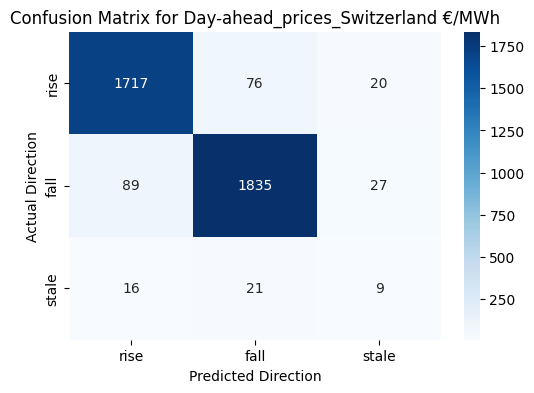

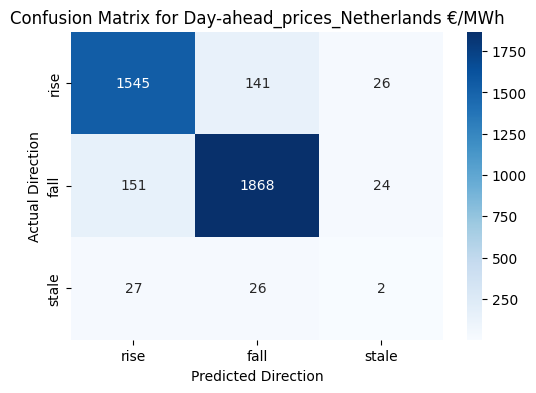

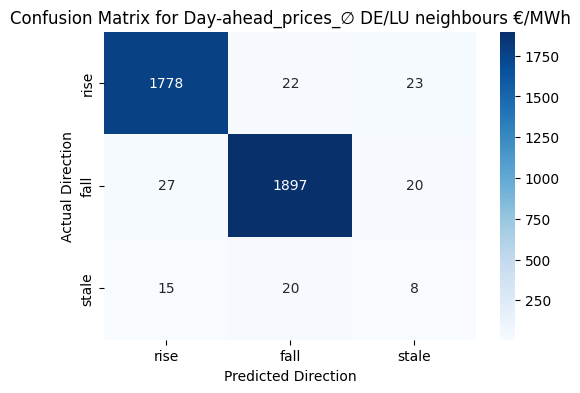

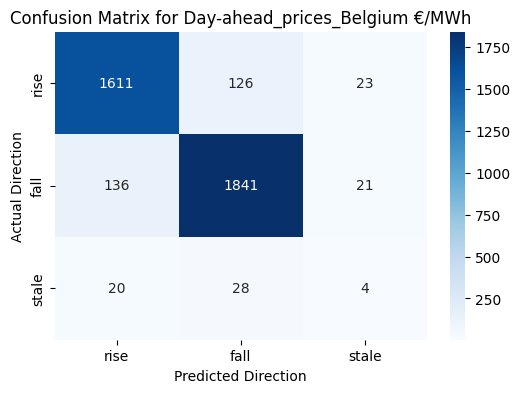

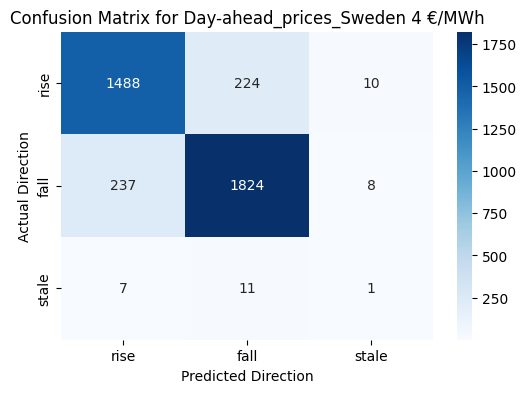

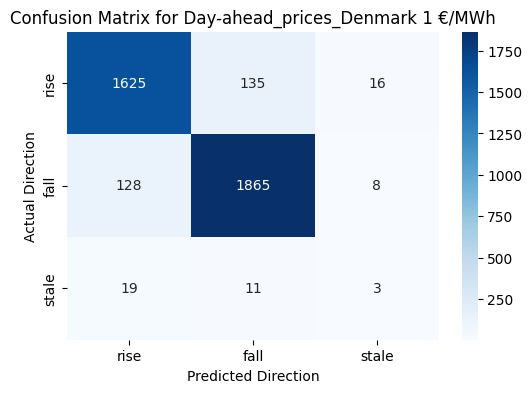

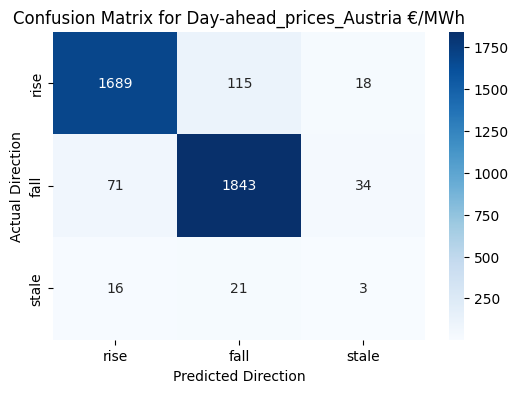

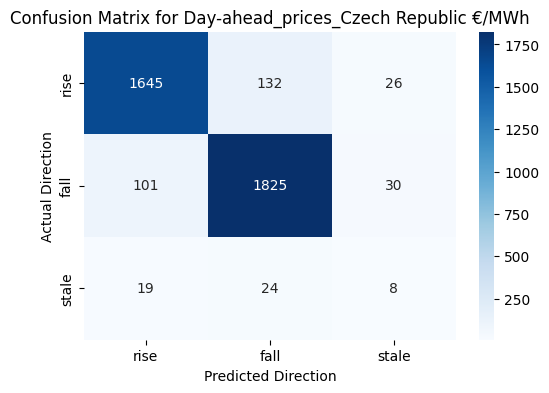

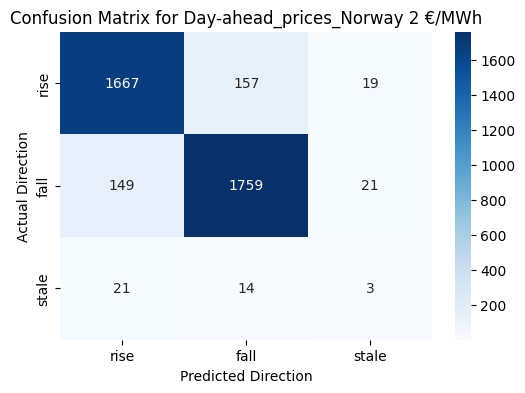

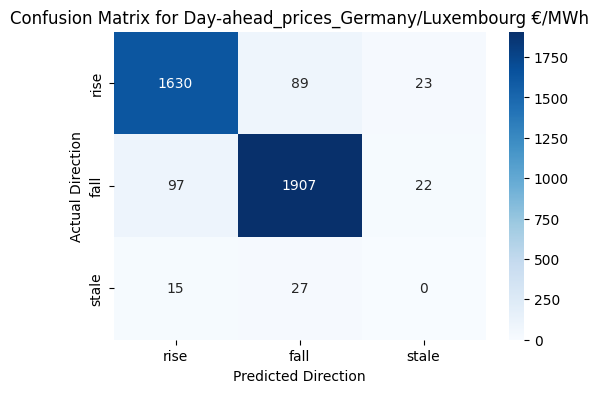

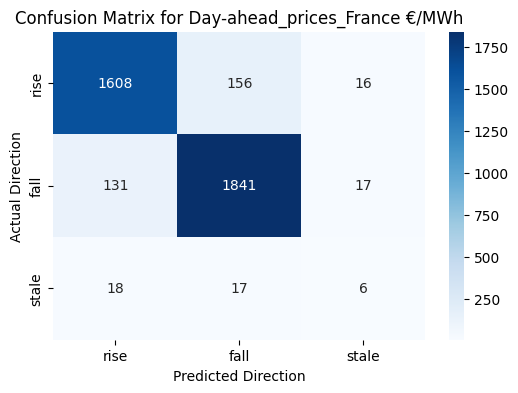

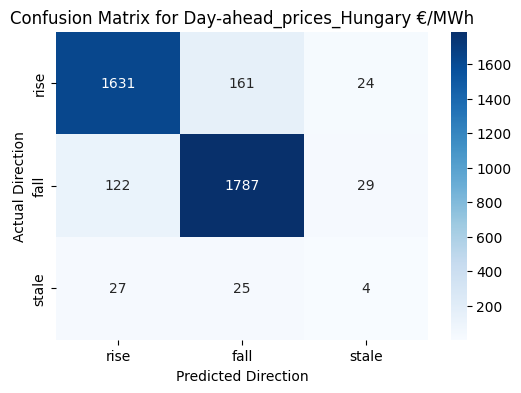

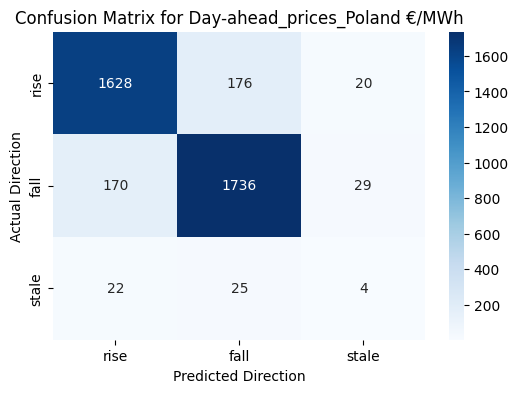

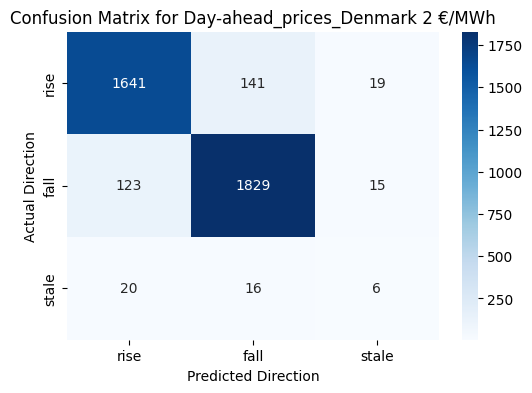

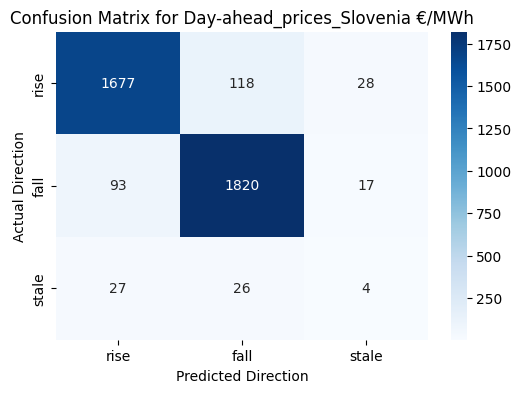

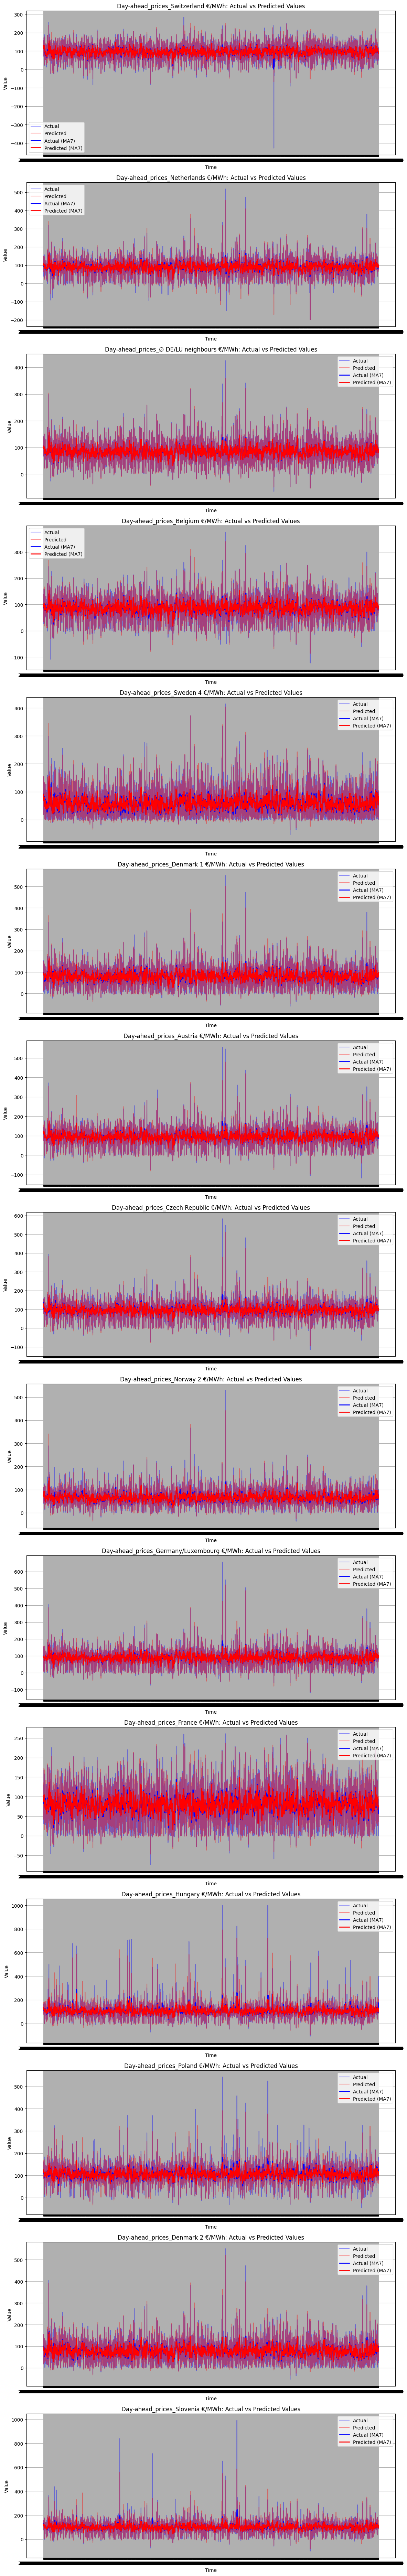

In [ ]:
cm = plot_direction_confusion_matrix(y_test, pred, price_cols, stable_threshold=0.01)
plot_prediction_movements(y_test, pred, window_size=7)

### Ensemble ridge

In [44]:


data = df.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace(',', ''))
data = data.drop(columns=['Day-ahead_prices_Northern Italy €/MWh', ])
# -------------------------------------------------------------------
price_cols = [col for col in data.columns if 'day-ahead_prices' in col.lower()]
# Test train split remains the same
original_target = data[price_cols]
X = data.drop(price_cols, axis=1)
y = data[price_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_original = original_target.loc[y_test.index]
print('y_test_original', y_test_original.shape)

# Meta-regressor
meta_reg = Ridge()

# Create base estimators
estimators = [
    ('rf', rf_model),
    ('lgbm', xgb_model),
]

# Wrap StackingRegressor with MultiOutputRegressor
stacking_base = StackingRegressor(estimators=estimators, final_estimator=meta_reg, n_jobs=-1)
stacking_ensemble = MultiOutputRegressor(stacking_base, n_jobs=-1)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Predict on test data
ensemble_predictions = stacking_ensemble.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test_original, ensemble_predictions)
mae = mean_absolute_error(y_test_original, ensemble_predictions)
r2 = r2_score(y_test_original, ensemble_predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)
threshold = 0.20 * np.mean(y_test_original)
extreme_actual = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_predicted = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_actual = extreme_actual[:len(extreme_predicted)]
extreme_accuracy = accuracy_score(extreme_actual, extreme_predicted)
print(f"Total extreme price movment accuracy: {extreme_accuracy * 100:.2f}%")



Mean Squared Error: 156.54698182594842
Mean Absolute Error: 7.004941836920476
Root Mean Squared Error: 12.511873633710836
R² Score: 0.9359849956220685
Total extreme price movment accuracy: 100.00%


In [48]:
stacking_ensemble

MultiOutputRegressor(estimator=StackingRegressor(estimators=[('rf',
                                                              RandomForestRegressor(max_features=0.5,
                                                                                    random_state=42)),
                                                             ('lgbm',
                                                              XGBRegressor(base_score=None,
                                                                           booster=None,
                                                                           callbacks=None,
                                                                           colsample_bylevel=None,
                                                                           colsample_bynode=None,
                                                                           colsample_bytree=None,
                                                                           device=None,
                                                                           early_stopping_rounds=None,
                                                                           enable_categorical=False,
                                                                           eval_metric=None,
                                                                           feature_types...
                                                                           interaction_constraints=None,
                                                                           learning_rate=0.1,
                                                                           max_bin=None,
                                                                           max_cat_threshold=None,
                                                                           max_cat_to_onehot=None,
                                                                           max_delta_step=None,
                                                                           max_depth=4,
                                                                           max_leaves=None,
                                                                           min_child_weight=None,
                                                                           missing=nan,
                                                                           monotone_constraints=None,
                                                                           multi_strategy=None,
                                                                           n_estimators=100,
                                                                           n_jobs=None,
                                                                           num_parallel_tree=None,
                                                                           random_state=42, ...))],
                                                 final_estimator=Ridge(),
                                                 n_jobs=-1),
                     n_jobs=-1)


Analyzing directional prediction accuracy...

Directional Accuracy for Day-ahead_prices_Switzerland €/MWh:
Overall: 93.47%
Rising: 94.70% (1717/1813)
Falling: 94.05% (1835/1951)
Stable: 21.28% (10/47)

Directional Accuracy for Day-ahead_prices_Netherlands €/MWh:
Overall: 89.64%
Rising: 90.25% (1545/1712)
Falling: 91.43% (1868/2043)
Stable: 5.36% (3/56)

Directional Accuracy for Day-ahead_prices_∅ DE/LU neighbours €/MWh:
Overall: 96.67%
Rising: 97.53% (1778/1823)
Falling: 97.58% (1897/1944)
Stable: 20.45% (9/44)

Directional Accuracy for Day-ahead_prices_Belgium €/MWh:
Overall: 90.71%
Rising: 91.53% (1611/1760)
Falling: 92.14% (1841/1998)
Stable: 9.43% (5/53)

Directional Accuracy for Day-ahead_prices_Sweden 4 €/MWh:
Overall: 86.96%
Rising: 86.41% (1488/1722)
Falling: 88.16% (1824/2069)
Stable: 10.00% (2/20)

Directional Accuracy for Day-ahead_prices_Denmark 1 €/MWh:
Overall: 91.68%
Rising: 91.50% (1625/1776)
Falling: 93.20% (1865/2001)
Stable: 11.76% (4/34)

Directional Accuracy for D

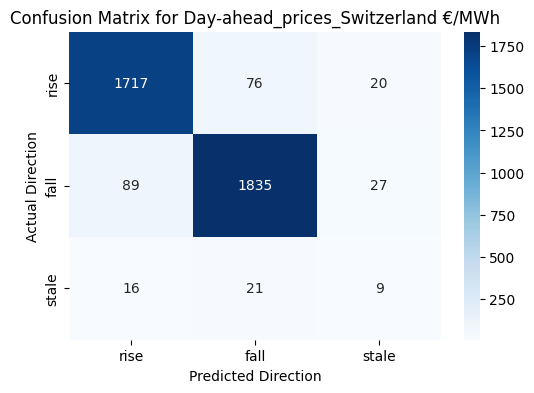

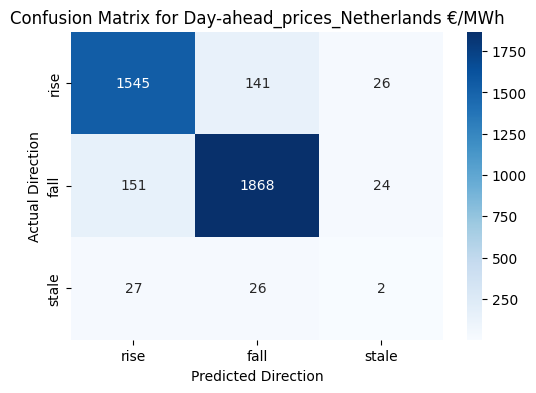

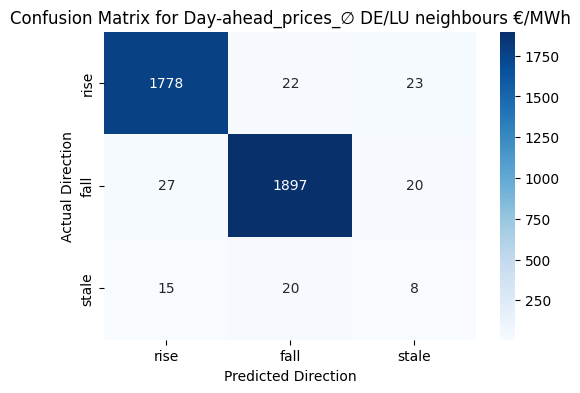

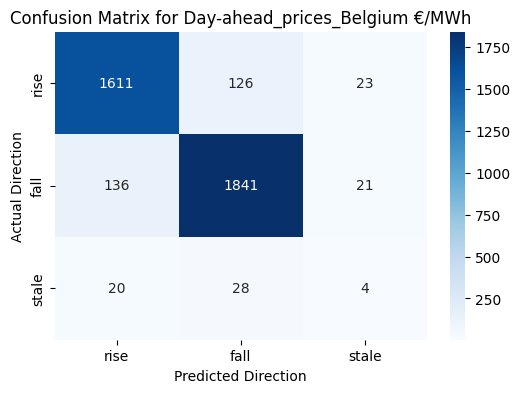

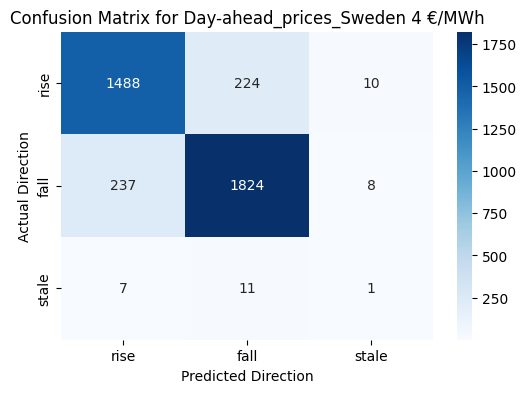

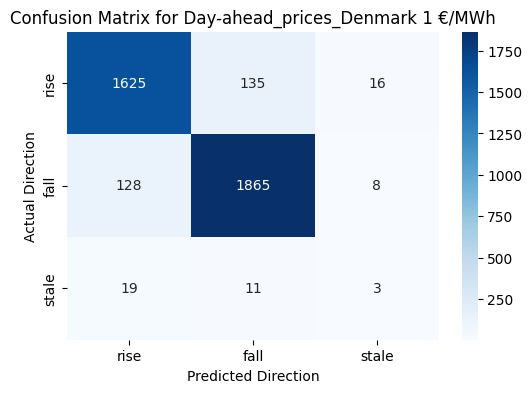

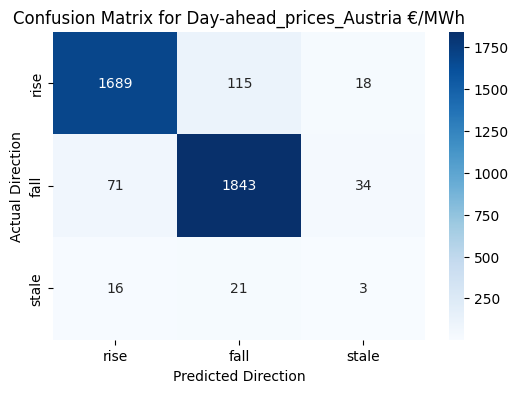

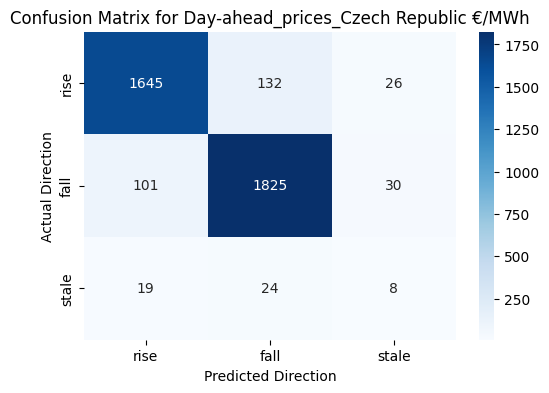

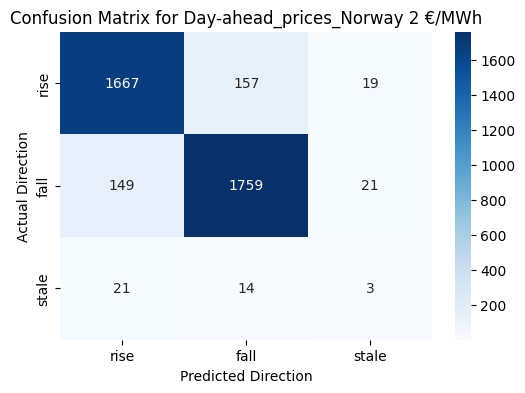

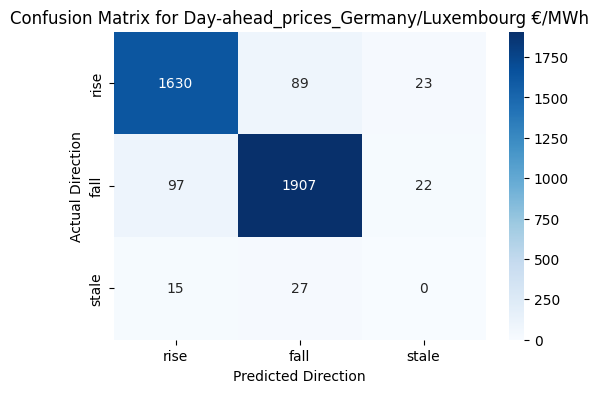

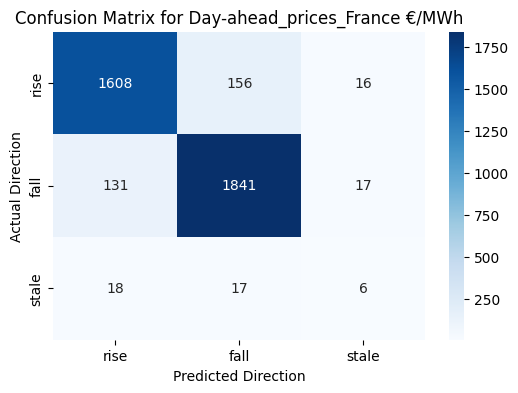

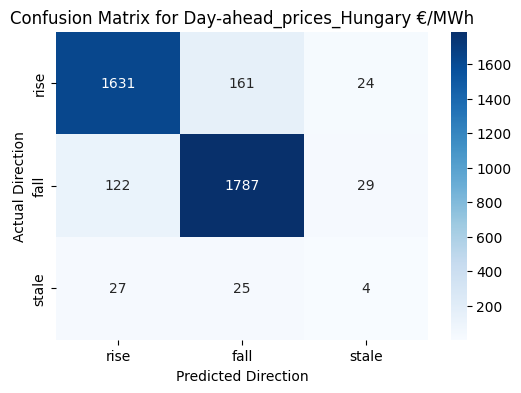

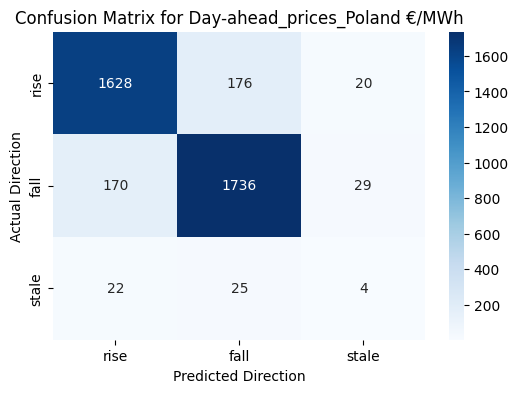

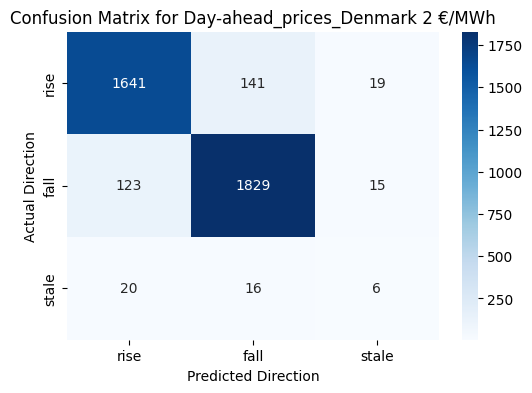

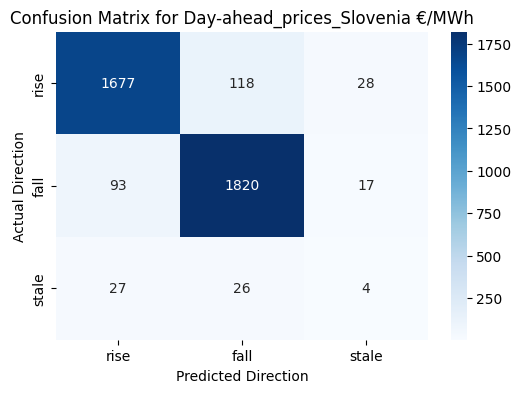

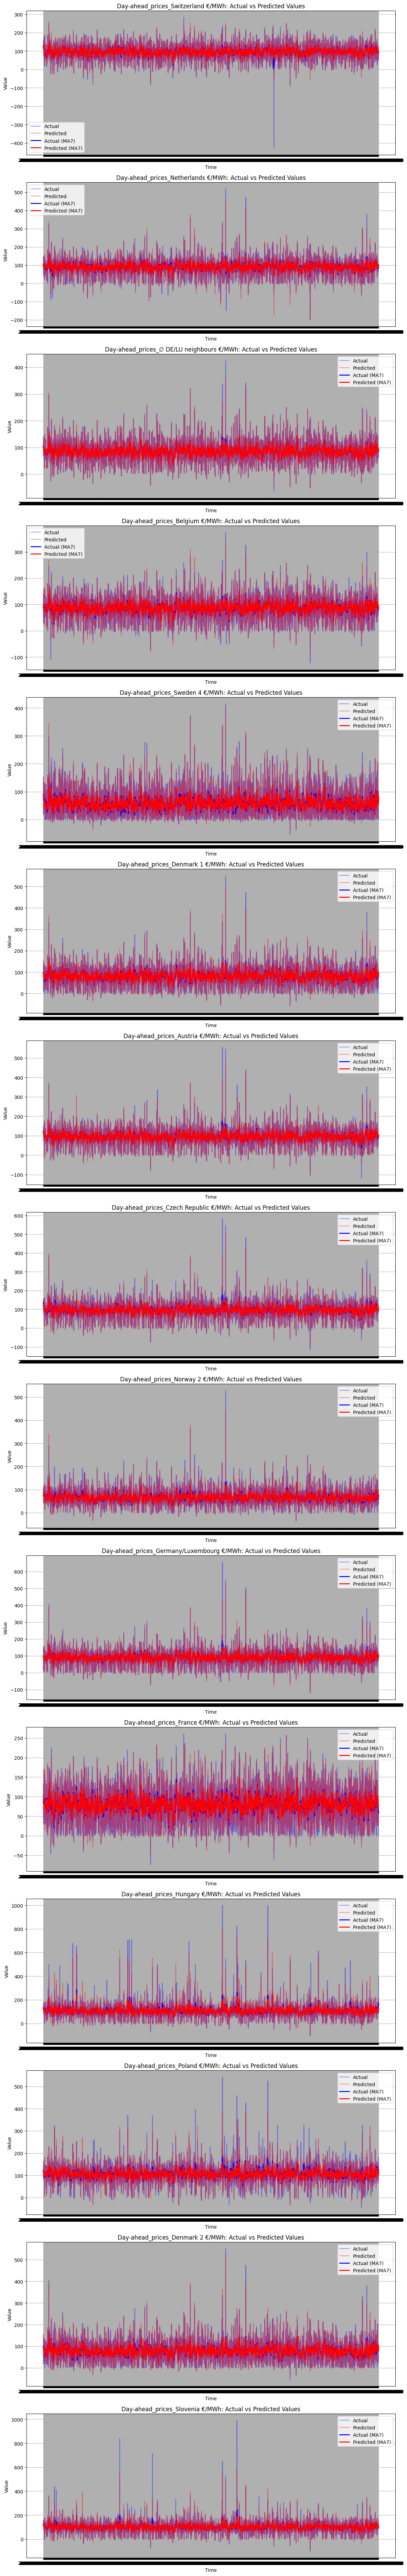

In [47]:

# Directional accuracy analysis
print("\nAnalyzing directional prediction accuracy...")
pred = pd.DataFrame(ensemble_predictions, columns=y_test_original.columns)
y_test = y_test_original.reset_index(drop=True)
directional_results = calculate_directional_accuracy(y_test, pred)

for col, results in directional_results.items():
    print(f"\nDirectional Accuracy for {col}:")
    print(f"Overall: {results['overall_accuracy']:.2f}%")
    for direction, metrics in results['direction_metrics'].items():
        print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")
cm = plot_direction_confusion_matrix(y_test, pred, price_cols, stable_threshold=0.01)
plot_prediction_movements(y_test, pred, window_size=7)

## Code Aggregation

In [ ]:
import os
import pickle
import requests
from zipfile import ZipFile
from tqdm import tqdm
import warnings
import numpy as np
import numpy
from scipy import stats
from scipy.stats import mstats
import math
warnings.filterwarnings("ignore")
import json
import pandas as pd
import pickle
import seaborn as sns
import random
import shap
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import gc
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
random.seed(42)
from sklearn.decomposition import PCA
np.random.seed(42)
# -----------------------------------model & analysis Function------------

def model_pipeline(model_type, df, target, cross_val=False, grid_search=False, transform=False):
    # Check if all target columns exist in the dataframe
    if all(cols in df.columns for cols in target):
        print('All target columns are present. Starting pipeline...')
    else:
        raise ValueError("Some target columns are missing in the dataframe.")

    # Transformation step (if enabled)
    if transform:
        print("Applying transformations to targets...")
        original_target = df[target].copy()

        # Apply Box-Cox transformation to each target column
        boxcox_lambdas = {}
        for col in target:
            df[col] = df[col].apply(lambda x: x if x >= 0 else 0)
            df[col], boxcox_lambda = stats.boxcox(df[col] + 1)
            boxcox_lambdas[col] = boxcox_lambda
            lower_percentile = np.percentile(df[col], 1)
            upper_percentile = np.percentile(df[col], 99)
            df[col] = np.clip(df[col], lower_percentile, upper_percentile)

        # Scale the transformed targets
        scaler = StandardScaler()
        df[target] = scaler.fit_transform(df[target])

    # Splitting data into features (X) and targets (y)
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if transform:
        y_test_original = original_target.loc[y_test.index]
        print('y_test_original shape:', y_test_original.shape)
    else:
        y_test_original = y_test

    # Further split for grid search (if applicable)
    X_grid, _, y_grid, _ = train_test_split(X_train, y_train, test_size=0.01, random_state=42)

    # Define model and parameter grid based on selected model type
    if model_type.lower() == 'random_forest':
        model = RandomForestRegressor(n_estimators=100,
                                      random_state=42,
                                      max_depth= None,
                                      max_features= 0.5,
                                      min_samples_leaf= 1,
                                      min_samples_split= 2,
                                      )
        param_grid = {
            'n_estimators': [100],
            'max_depth': [None, 2, 4],
            'min_samples_split': [2, 4],
            'min_samples_leaf': [1, 3],
            'max_features': ['auto', 'sqrt', 0.5, 0.75, 1.0]
        }
    elif model_type.lower() == 'xgboost':
        model = XGBRegressor(n_estimators=100,
                             random_state=42,
                             gamma=0,
                             learning_rate=0.1,
                             max_depth=4,
                             subsample=0.5)
        param_grid = {
            'n_estimators': [100],
            'max_depth': [2, 4],
            'learning_rate': [0.01, 0.1],
            'gamma': [0, 1.0],
            'subsample': [0.5, 1.0]
        }
    elif model_type.lower() == 'catboost':
        model = CatBoostRegressor(iterations=300, random_seed=42)
        param_grid = {
            'iterations': [100, 300],
            'depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'l2_leaf_reg': [0, 0.5, 1.0],
            'border_count': [32, 64]
        }
    else:
        raise ValueError("Unsupported model_type. Choose from 'random_forest', 'xgboost', or 'catboost'.")

    # Perform grid search hyperparameter tuning (if enabled)
    if grid_search:
        print("Starting grid search for hyperparameter tuning...")
        print('Data for grid search:', X_grid.shape)
        grid = GridSearchCV(estimator=model,
                            param_grid=param_grid,
                            cv=5,
                            scoring='neg_mean_squared_error',
                            n_jobs=-1)
        grid.fit(X_grid, y_grid)
        print("Best parameters from Grid Search:", grid.best_params_)
        best_model = grid.best_estimator_
    else:
        best_model = model

    # Perform cross-validation (if enabled)
    if cross_val:
        print("Performing 5-fold cross-validation...")
        cv_scores = cross_val_score(best_model,
                                    X,
                                    y,
                                    scoring='neg_mean_squared_error',
                                    cv=5,
                                    n_jobs=-1)
        print("Cross Validation Scores (neg MSE):", cv_scores)
        print("Mean CV Score (neg MSE):", cv_scores.mean())

    # Train the final model on the training set
    print("Training the model...")
    best_model.fit(X_train, y_train)

    print("Model training is complete.")

    # Feature importance extraction and visualization
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
        imp_df = pd.DataFrame({'feature': X_train.columns,
                               'importance': importances})
        imp_df.sort_values(by='importance', ascending=False, inplace=True)

        print("Feature Importances:")
        print(imp_df)

        imp_df.plot(kind='bar', x='feature', y='importance', figsize=(12, 8),
                    title="Feature Importances")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    else:
        print("The selected model does not support a 'feature_importances_' attribute.")
#---------------------------------------- Prediction -------------------------------------------
    print('Making predictions...')

    if transform:
        y_pred_scaled = best_model.predict(X_test).reshape(-1, len(target))

        # Inverse scaling and Box-Cox transformation for each target column
        y_pred_original_dict = {}

        for i, col in enumerate(target):
            y_pred_boxcox_col = scaler.inverse_transform(y_pred_scaled)[:, i]
            y_pred_original_dict[col] = inv_boxcox(y_pred_boxcox_col + 1e-9,
                                                   boxcox_lambdas[col]) - 1

        y_pred_original = pd.DataFrame(y_pred_original_dict,
                                       index=X_test.index,
                                       columns=target)

    else:
        y_pred_original = pd.DataFrame(best_model.predict(X_test),
                                       index=X_test.index,
                                       columns=target)
    y_pred_clean = y_pred_original
    y_test_clean = y_test_original

    mse = mean_squared_error(y_test_clean.values, y_pred_clean.values)
    mae = mean_absolute_error(y_test_clean.values, y_pred_clean.values)
    r2 = r2_score(y_test_clean.values, y_pred_clean.values)
    rmse = math.sqrt(mse)
    print(f"Root Mean Square Error: {rmse}")
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R² Score:", r2)

    threshold = 0.10 * np.mean(y_test_clean)
    extreme_actual = np.abs(np.diff(y_pred_clean)) > threshold
    extreme_predicted = np.abs(np.diff(y_pred_clean)) > threshold
    extreme_actual = extreme_actual[:len(extreme_predicted)]
    extreme_accuracy = accuracy_score(extreme_actual, extreme_predicted)
    print(f"Total extreme price movment accuracy: {extreme_accuracy * 100:.2f}%")

    print("\nAnalyzing directional prediction accuracy...")
    directional_results = calculate_directional_accuracy(y_test_clean, y_pred_clean)

    for col, results in directional_results.items():
        print(f"\nDirectional Accuracy for {col}:")
        print(f"Overall: {results['overall_accuracy']:.2f}%")
        for direction, metrics in results['direction_metrics'].items():
            print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")
    # # Visualize movement comparison
    cm = plot_direction_confusion_matrix(y_test_clean, y_pred_clean, target, stable_threshold=0.01)
    plot_prediction_movements(y_test_clean, y_pred_clean, window_size=7)

    return best_model , X_test , y_test_clean , y_pred_clean

def calculate_directional_accuracy(y_test, y_pred, target_cols=None, stable_threshold=0.01):
    """
    Calculate what percentage of predictions correctly identify the direction
    of movement (rising, falling, or stable).

    Parameters:
    -----------
    y_test : DataFrame - Actual target values
    y_pred : DataFrame - Predicted target values
    target_cols : list - Target columns to analyze
    stable_threshold : float - Threshold for classifying as stable

    Returns:
    --------
    DataFrame - Directional accuracy metrics
    """
    if target_cols is None:
        target_cols = y_test.columns

    results = {}

    for col in target_cols:
        # Calculate percentage changes to determine direction
        test_pct_change = y_test[col].pct_change().fillna(0)
        pred_pct_change = y_pred[col].pct_change().fillna(0)
        # Classify movements as rising, falling, or stable
        def classify_direction(series, threshold):
            directions = pd.Series(index=series.index)
            directions[series > threshold] = 'rising'
            directions[series < -threshold] = 'falling'
            directions[(series >= -threshold) & (series <= threshold)]= 'stable'
            return directions

        test_direction = classify_direction(test_pct_change, stable_threshold)
        pred_direction = classify_direction(pred_pct_change, stable_threshold)

        # Overall directional accuracy
        correct = (test_direction == pred_direction)
        overall_accuracy = correct.mean() * 100

        # Accuracy by direction type
        direction_metrics = {}
        for direction in ['rising', 'falling', 'stable']:
            actual_direction = (test_direction == direction)
            count = actual_direction.sum()

            if count > 0:
                correct_dir = ((test_direction == direction) & (pred_direction == direction)).sum()
                accuracy = (correct_dir / count) * 100
            else:
                correct_dir = 0
                accuracy = 0

            direction_metrics[direction] = {
                'count': int(count),
                'correct': int(correct_dir),
                'accuracy': float(accuracy)
            }

        results[col] = {
            'overall_accuracy': float(overall_accuracy),
            'direction_metrics': direction_metrics
        }

    return results


def plot_direction_confusion_matrix(y_test, y_pred, target_cols, stable_threshold=0.01):

    # Ensure y_test and y_pred are DataFrames
    if not isinstance(y_test, pd.DataFrame) or not isinstance(y_pred, pd.DataFrame):
        raise ValueError("y_test and y_pred must be pandas DataFrames.")

    # Ensure target_cols exist in both y_test and y_pred
    for col in target_cols:
        if col not in y_test.columns or col not in y_pred.columns:
            raise ValueError(f"Column {col} not found in y_test or y_pred.")

    # Initialize a dictionary to store confusion matrices
    confusion_matrices = {}

    for col in target_cols:
        # Calculate percentage change for actual and predicted values
        actual_change = y_test[col].pct_change().dropna()
        predicted_change = y_pred[col].pct_change().dropna()

        # Align actual and predicted changes
        aligned_index = actual_change.index.intersection(predicted_change.index)
        actual_change = actual_change.loc[aligned_index]
        predicted_change = predicted_change.loc[aligned_index]

        # Classify changes into rise, fall, or stale
        actual_direction = np.where(actual_change > stable_threshold, 'rise',
                                   np.where(actual_change < -stable_threshold, 'fall', 'stale'))
        predicted_direction = np.where(predicted_change > stable_threshold, 'rise',
                                      np.where(predicted_change < -stable_threshold, 'fall', 'stale'))

        # Create confusion matrix
        cm = confusion_matrix(actual_direction, predicted_direction, labels=['rise', 'fall', 'stale'])
        confusion_matrices[col] = cm

        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['rise', 'fall', 'stale'],
                    yticklabels=['rise', 'fall', 'stale'])
        plt.title(f'Confusion Matrix for {col}')
        plt.xlabel('Predicted Direction')
        plt.ylabel('Actual Direction')
        plt.show()

    return confusion_matrices
def plot_prediction_movements(y_test, y_pred, target_cols=None, window_size=7):
    """
    Plot actual vs predicted values with moving averages to visualize trends.

    Parameters:
    -----------
    y_test : DataFrame - Actual target values
    y_pred : DataFrame - Predicted target values
    target_cols : list - Target columns to visualize (defaults to all)
    window_size : int - Window size for moving average
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Handle target columns
    if target_cols is None:
        target_cols = y_test.columns

    # Create visualization
    n_targets = len(target_cols)
    fig, axes = plt.subplots(n_targets, 1, figsize=(12, 5 * n_targets))
    if n_targets == 1:
        axes = [axes]

    for i, col in enumerate(target_cols):
        ax = axes[i]

        # Plot raw values
        ax.plot(dates.loc[y_test.index]['End date'], y_test[col], 'b-', alpha=0.4, label='Actual')
        ax.plot(dates.loc[y_test.index]['End date'], y_pred[col], 'r-', alpha=0.4, label='Predicted')

        # Plot moving averages for clearer trend visualization
        y_test_ma = y_test[col].rolling(window=window_size, center=True, min_periods=1).mean()
        y_pred_ma = y_pred[col].rolling(window=window_size, center=True, min_periods=1).mean()

        ax.plot(dates.loc[y_test.index]['End date'], y_test_ma, 'b-', linewidth=2, label=f'Actual (MA{window_size})')
        ax.plot(dates.loc[y_test.index]['End date'], y_pred_ma, 'r-', linewidth=2, label=f'Predicted (MA{window_size})')

        ax.set_title(f'{col}: Actual vs Predicted Values')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# -----------------------------------------load the data ----------------------------------
dates= pd.read_csv('dates.csv')
df = pd.read_csv('normalized_features.csv')
imputed_df = pd.read_csv('transformed_imputed_5_features.csv')

# ------------------------------------Missing Imputation-----------------------------

imputed_cols = ['Natural Gas Price',
'Frequency_Containment_Reserve_Procurement price [€/MW]',
'Automatic_Frequency_Restoration_Reserve_Procurement price (+) [€/MW]',
'Manual_Frequency_Restoration_Reserve_Procurement price (+) [€/MW]',
'Manual_Frequency_Restoration_Reserve_Procurement price (-) [€/MW]']
for col in imputed_cols:
  df[col]= imputed_df[col]

# ------------------------------run the models -----------------------------------------
dff = df.drop(columns=['Day-ahead_prices_Northern Italy [€/MWh]'])
price_cols = [col for col in dff.columns if 'day-ahead_prices' in col.lower()]
rf_model , X_test , y_test , predictions = model_pipeline(
                                            model_type="random_forest",
                                            df=dff,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=False,
                                            target=price_cols )

data = df.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace(',', ''))
data = data.drop(columns=['Day-ahead_prices_Northern Italy €/MWh', ])
price_cols = [col for col in data.columns if 'day-ahead_prices' in col.lower()]
xgb_model,X_test, y_test , y_pred_org = model_pipeline(model_type="xgboost",
                                            df=data,
                                            cross_val=False,
                                            grid_search=False,
                                            transform=False,
                                            target =price_cols )


# ----------------------------Ridge -------------------------------------------------

# Meta-regressor
meta_reg = Ridge()

# Create base estimators
estimators = [
    ('rf', rf_model),
    ('lgbm', xgb_model),
]

# Wrap StackingRegressor with MultiOutputRegressor
stacking_base = StackingRegressor(estimators=estimators, final_estimator=meta_reg, n_jobs=-1)
stacking_ensemble = MultiOutputRegressor(stacking_base, n_jobs=-1)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Predict on test data
ensemble_predictions = stacking_ensemble.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test_original, ensemble_predictions)
mae = mean_absolute_error(y_test_original, ensemble_predictions)
r2 = r2_score(y_test_original, ensemble_predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)
threshold = 0.10 * np.mean(y_test_original)
extreme_actual = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_predicted = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_actual = extreme_actual[:len(extreme_predicted)]
extreme_accuracy = accuracy_score(extreme_actual, extreme_predicted)
print(f"Total extreme price movment accuracy: {extreme_accuracy * 100:.2f}%")

for col, results in directional_results.items():
    print(f"\nDirectional Accuracy for {col}:")
    print(f"Overall: {results['overall_accuracy']:.2f}%")
    for direction, metrics in results['direction_metrics'].items():
        print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")
cm = plot_direction_confusion_matrix(y_test, pred, price_cols, stable_threshold=0.01)
plot_prediction_movements(y_test, pred, window_size=7)


# --------------------------Linear regression ensemble ----------------------------
# Meta-regressor
meta_reg = LinearRegression()

# Create base estimators
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    # ('catboost', catboost_model)
]

# Wrap StackingRegressor with MultiOutputRegressor
stacking_base = StackingRegressor(estimators=estimators, final_estimator=meta_reg)
stacking_ensemble = MultiOutputRegressor(stacking_base)

# Train the stacking ensemble
stacking_ensemble.fit(X_train, y_train)

# Predict on test data - already in correct shape (n_samples, n_targets)
ensemble_predictions = stacking_ensemble.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test_original, ensemble_predictions)
mae = mean_absolute_error(y_test_original, ensemble_predictions)
r2 = r2_score(y_test_original, ensemble_predictions)
rmse = np.sqrt(mse)  # Add RMSE calculation

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)
threshold = 0.10 * np.mean(y_test_original)
extreme_actual = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_predicted = np.abs(np.diff(ensemble_predictions)) > threshold
extreme_actual = extreme_actual[:len(extreme_predicted)]
extreme_accuracy = accuracy_score(extreme_actual, extreme_predicted)
print(f"Total extreme price movment accuracy: {extreme_accuracy * 100:.2f}%")

print("\nAnalyzing directional prediction accuracy...")
pred = pd.DataFrame(ensemble_predictions, columns= y_test_original.columns)
y_test = y_test_original.reset_index()
y_test.drop(columns=['index'], inplace=True)
directional_results = calculate_directional_accuracy(y_test, pred)

for col, results in directional_results.items():
    print(f"\nDirectional Accuracy for {col}:")
    print(f"Overall: {results['overall_accuracy']:.2f}%")
    for direction, metrics in results['direction_metrics'].items():
        print(f"{direction.capitalize()}: {metrics['accuracy']:.2f}% ({metrics['correct']}/{metrics['count']})")
cm = plot_direction_confusion_matrix(y_test, pred, price_cols, stable_threshold=0.01)
plot_prediction_movements(y_test, pred, window_size=7)